In [3]:
!pip install yfinance

# After installation, you can import the packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Verify installation
print(f"yfinance version: {yf.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.9-cp312-cp312-macosx_11_0_arm64.whl size=264338 sha256=7eb30334d24699ea838b7811d0b9b862118fd1f9fbda64c4aa736300cc25ac1b
  Stored in directory: /Users/sriganeshk/Library/Caches/pip/wheels/43/ef/2d/2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee
yfinance version: 0.2.55


In [5]:
# Download historical stock prices (e.g., Apple Inc.)
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')

# Display first few rows
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320431,24.789800,23.879980,24.778677,212818400
2015-01-05,23.635284,24.169164,23.448427,24.089082,257142000
2015-01-06,23.637514,23.897780,23.274920,23.699800,263188400
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600
2015-01-08,24.889900,24.947738,24.180285,24.298185,237458000


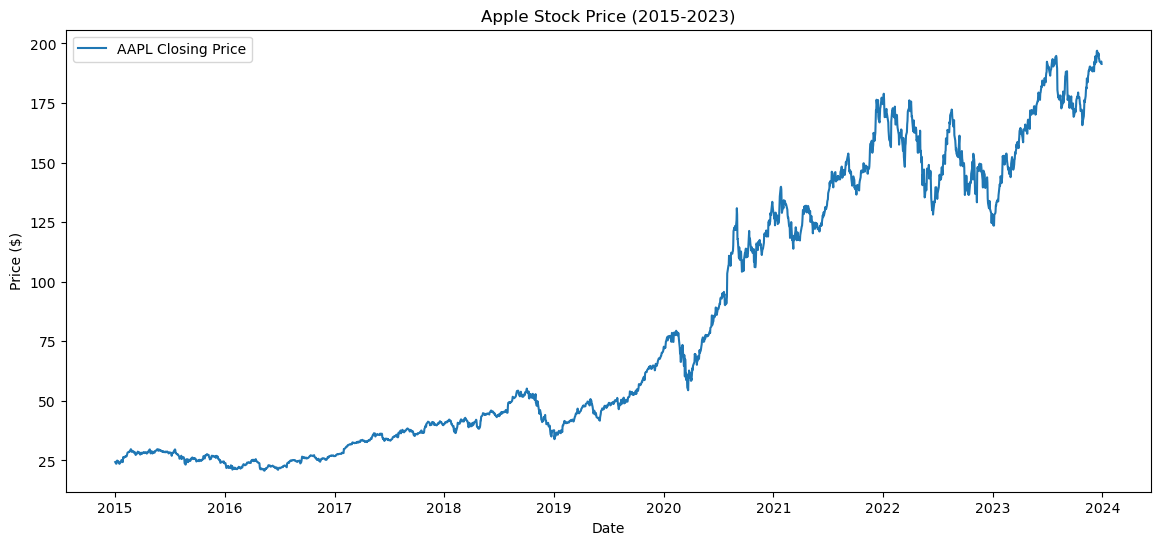

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='AAPL Closing Price')
plt.title('Apple Stock Price (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [17]:
# First, check if DataFrame is not empty and has data
if df.empty:
    raise ValueError("The input DataFrame is empty")

# Print available columns to help identify the correct one
print("Available columns:", df.columns.tolist())

# First, check if 'Close' column exists in the DataFrame (case-insensitive)
close_columns = []
for col in df.columns:
    # Check if column name is a string before calling .lower()
    if isinstance(col, str) and col.lower() == 'close':
        close_columns.append(col)

if close_columns:
    # Use the first matching 'close' column (case-insensitive)
    data = df[[close_columns[0]]]
else:
    # If no 'close' column, use the first numerical column as a fallback
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"No 'Close' column found. Using '{numeric_cols[0]}' instead.")
        data = df[[numeric_cols[0]]]
    else:
        raise ValueError("No suitable numerical column found in the DataFrame")

# Ensure data is not empty and doesn't contain NaN values
if data.empty:
    raise ValueError("The filtered DataFrame is empty")

# Handle any NaN values
if data.isna().any().any():
    print("Warning: NaN values found in data. Filling with forward fill method.")
    data = data.fillna(method='ffill').fillna(method='bfill')  # Forward fill then backward fill any remaining NaNs

dataset = data.values

# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Training data
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[0:training_data_len, :]

# Make sure we have enough data points for the sequence length
sequence_length = 60
if len(train_data) <= sequence_length:
    raise ValueError(f"Not enough data points. Need more than {sequence_length} points.")

X_train = []
y_train = []

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

# Convert to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Available columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
No 'Close' column found. Using '('Close', 'AAPL')' instead.


In [23]:
!pip install tensorflow

# After installation, import the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Optional: Print model summary to verify the architecture
model.summary()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 10.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 9.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.5 MB/s eta 0:00:00a 0:00:01


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# Create the LSTM model using the recommended approach
model = Sequential([
    # Start with an Input layer that specifies the shape
    Input(shape=(X_train.shape[1], 1)),
    
    # Add LSTM layers
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    
    # Add Dense layers
    Dense(25),
    Dense(1)
])

# Optional: Print model summary to verify the architecture
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# Note: You might want to adjust epochs and batch_size based on your dataset
model.fit(X_train, y_train, batch_size=32, epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0337
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1239e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.1783e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0047e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8363e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7040e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6189e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5349e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8878e-04
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5514e-04


In [27]:
# Create test data
test_data = scaled_data[training_data_len - 60:, :]
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


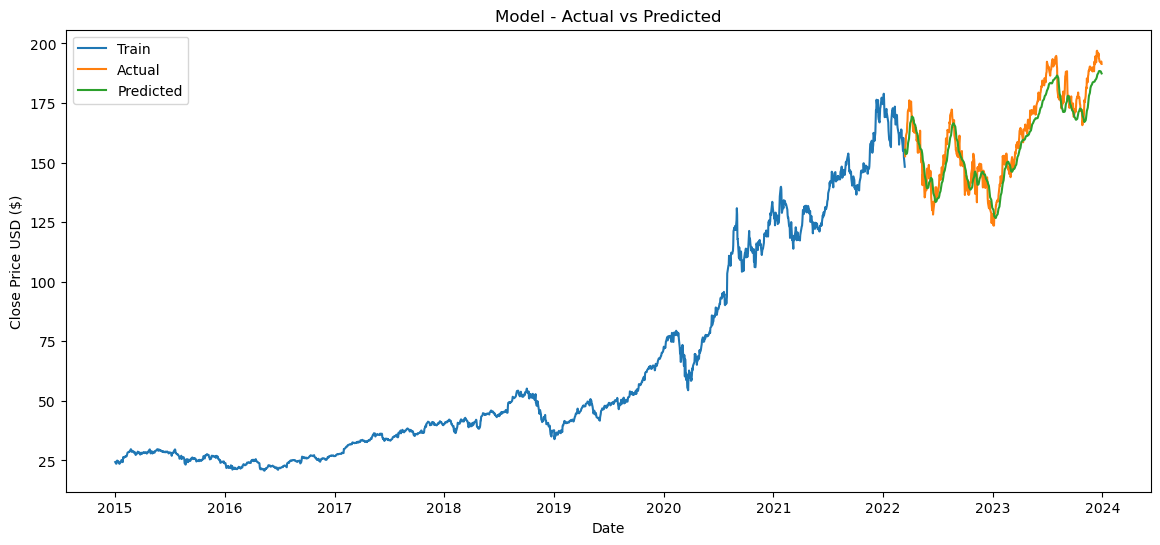

In [37]:
# Instead of:
# valid['Predictions'] = predictions

# Use .loc to avoid the SettingWithCopyWarning
valid.loc[:, 'Predictions'] = predictions

# Alternatively, if you want to ensure you're working with a copy:
valid = valid.copy()
valid['Predictions'] = predictions

plt.figure(figsize=(14,6))
plt.title('Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'])
plt.show()

In [39]:
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_input = np.reshape(last_60_days_scaled, (1, 60, 1))
predicted_price = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted next day closing price: ${predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted next day closing price: $187.06
